In [1]:
import tensorflow as tf
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt

In [2]:
# Adapted from the DeepDream Tutorial (https://www.tensorflow.org/tutorials/generative/deepdream) by TensorFlow Authors (2019)

# Some image-related helper functions
# Convert activations in [-1, 1] to an image in [0, 255]
def activation_to_image(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image in the notebook, optionall with smoothing
def plot_image(img, smooth=0):
  if smooth>0:
    img = ndimage.gaussian_filter(img, sigma=(smooth, smooth, 0), order=0)
    plot_image(img)
  else:
    plt.figure(figsize=(5,5))
    plt.imshow(np.array(img))

In [3]:
# Use a pre-trained network and extract its features.
# VGG19 is nice as it is also present on the OpenAi Microscope,
# so we can see if we find the same results.
# https://microscope.openai.com/models/vgg19_caffe/conv4_1_conv4_1_0?models.op.feature_vis.type=channel&models.op.technique=feature_vis

# Other networks:
# dir(tf.keras.applications)

base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

2022-04-02 16:22:57.868781: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-02 16:22:57.869417: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
def maximize_activation(layer="mixed0", index=0, img=None, steps=10, step_size=0.1):
    # Create a model using all the VGG19 layers from the input until reaching this layer
    layers = [base_model.get_layer(layer).output]
    dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
    
    # The following is the __call__ method from TensorFlow's DeepDream class
    # (https://www.tensorflow.org/tutorials/generative/deepdream)
    # The gradient_ascent function, in a loop, computes the derivative
    # of the image pixel values with respect to the activation, and then
    # adds this derivative to increase the activation.    
    @tf.function(
        # Decorator to increase the speed of the gradient_ascent function
        input_signature=(
          tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
          tf.TensorSpec(shape=[], dtype=tf.int32),
          tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def gradient_ascent(img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
              # This needs gradients relative to `img`
              # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                activation = dream_model(tf.expand_dims(img, axis=0))
                loss = tf.math.reduce_mean(activation[:,:,:,index])

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)
        return loss, img

    # Convert the starting image to make it a suitable input for the gradient_ascent
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    # Run the gradient ascent loop
    loss, img = gradient_ascent(img, tf.constant(steps), tf.constant(step_size))
    # Return the new image
    return activation_to_image(img)


Tracing


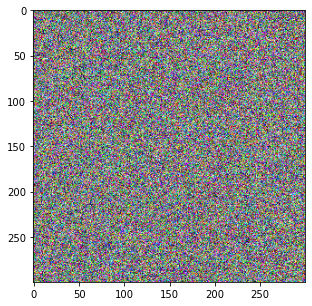

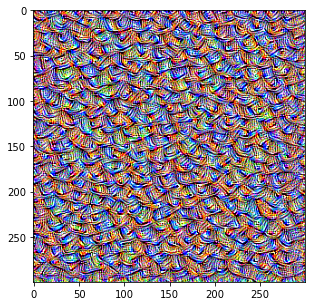

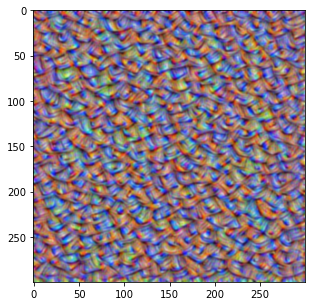

In [5]:
# Starting image -- random noise is a popular option,
# but uniform images work as well (and make nicer pictures if that is the goal)

input_img = np.random.randint(low=0,high=255,size=(300,300,3), dtype=np.uint8)
#input_img = np.zeros((300,300,3), dtype=np.uint8)
plot_image(input_img, smooth=0)

# Make an image that maximized the node 47 in the layer "block5_conv1" of VGG19:
optimized_img = maximize_activation(layer="block4_conv1", index=47,
                                  img=input_img, 
                                  steps=20, step_size=0.1)
plot_image(optimized_img, smooth=0)
plot_image(optimized_img, smooth=1)

In [6]:
# Now let's reproduce some pictures from the OpenAI Microscope
# Unit 4 in conv4_1 i.e. block4_conv1, index=4
# https://microscope.openai.com/models/vgg19_caffe/conv4_1_conv4_1_0?models.op.feature_vis.type=channel&models.op.technique=feature_vis

From OpenAI Microscope: ![conv4_1](https://oaiggoh.blob.core.windows.net/microscopeprod/2020-07-25/2020-07-25/vgg19_caffe/lucid.feature_vis/_feature_vis/alpha%3DFalse%26negative%3DFalse%26objective%3Dchannel%26op%3Dconv4_1%252Fconv4_1%253A0%26repeat%3D0%26start%3D0%26steps%3D4096%26stop%3D32/channel-4.png)

Tracing


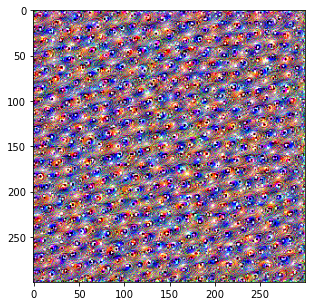

In [7]:
input_img = np.random.randint(low=0,high=255,size=(300,300,3), dtype=np.uint8)
optimized_img = maximize_activation(layer="block4_conv1", index=4,
                                  img=input_img, 
                                  steps=20, step_size=0.1)
plot_image(optimized_img)

In [8]:
# Now let's make some nice images from InceptionV3 (that's what the tutorial used and I played around with for a while)

In [9]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

0
Tracing
1
Tracing
2
Tracing
3
Tracing
4
Tracing
5
Tracing
6
Tracing
7
Tracing
8
Tracing
9
Tracing
10
Tracing
11
Tracing
12
Tracing
13
Tracing
14
Tracing
15
Tracing
16
Tracing
17
Tracing
18
Tracing
19
Tracing
20
Tracing


/tmp/ipykernel_80219/3729207188.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,5))


21
Tracing
22
Tracing
23
Tracing
24
Tracing
25
Tracing
26
Tracing
27
Tracing
28
Tracing
29
Tracing


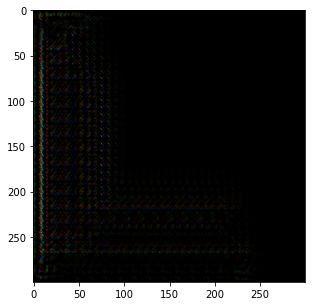

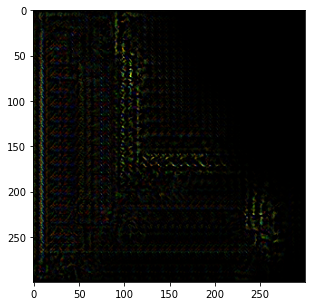

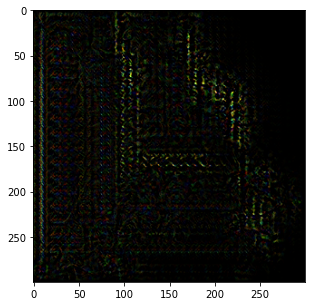

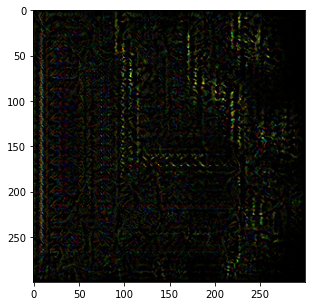

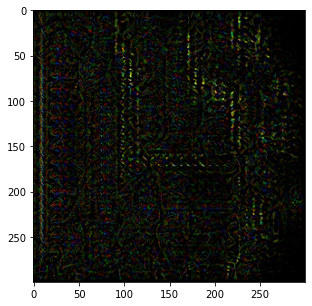

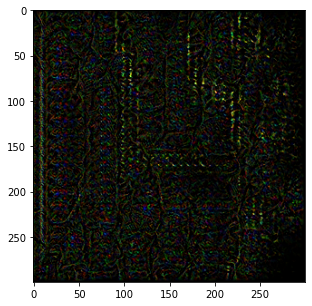

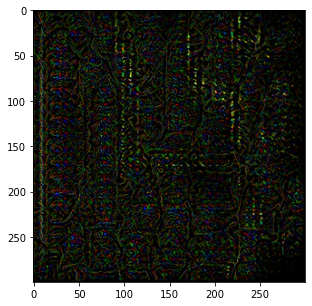

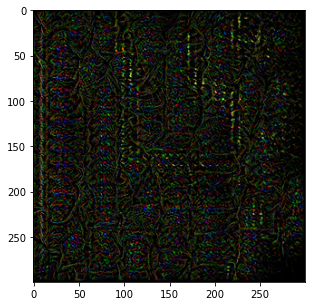

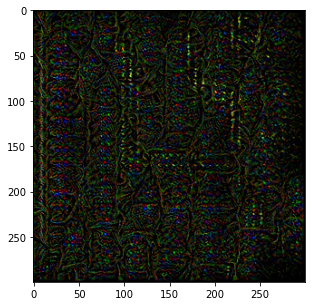

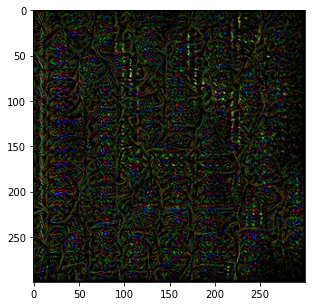

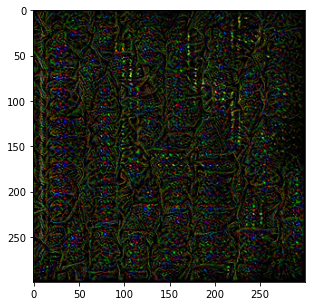

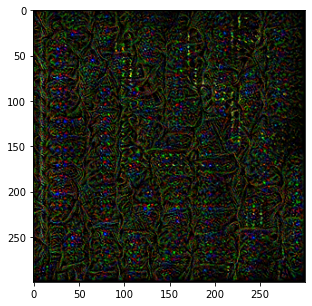

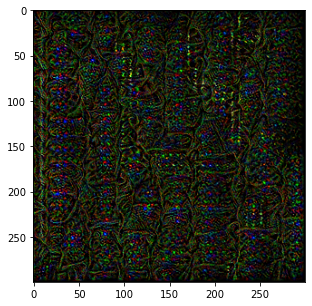

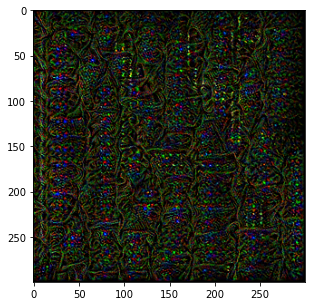

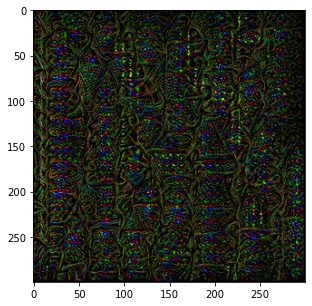

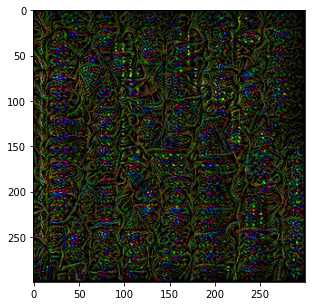

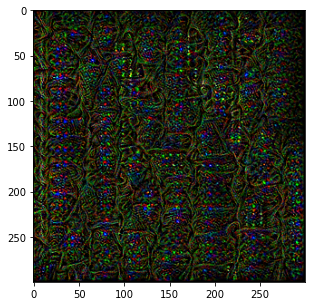

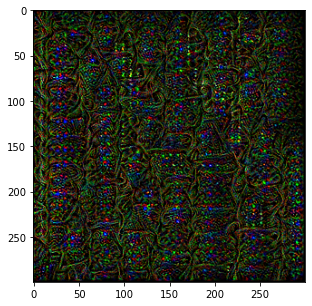

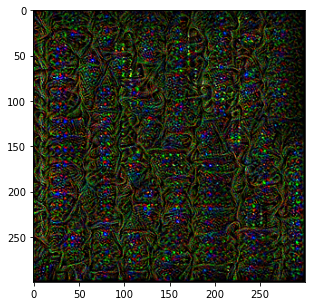

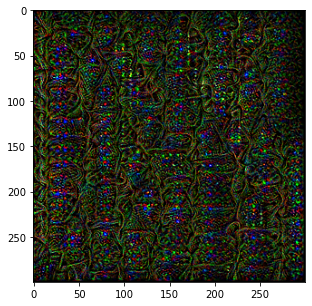

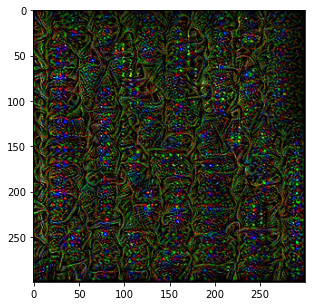

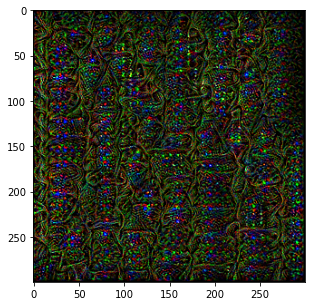

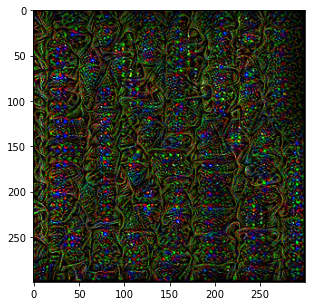

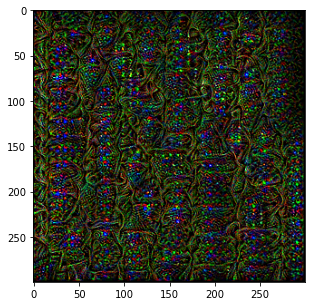

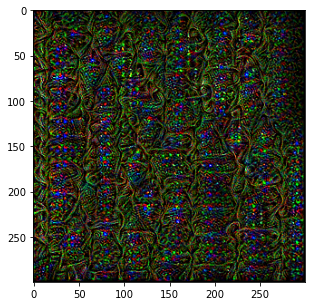

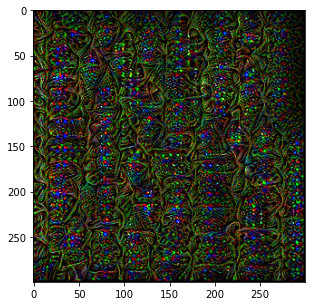

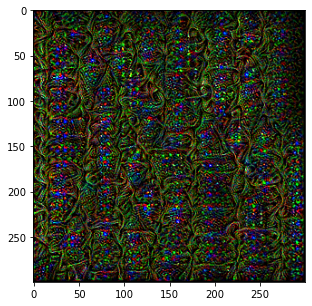

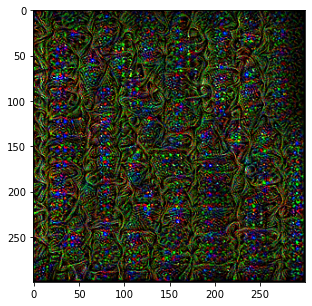

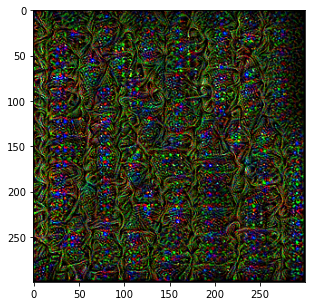

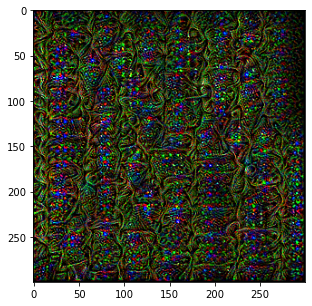

In [10]:
# Let's look at the process step-by-step and make a gif.
# Yes this isn't the fastest way to code this but we're just making a video.
images = [np.zeros((300,300,3), dtype=np.uint8)]
for i in range(30):
    print(i)
    images.append(maximize_activation(layer="mixed3", index=1,
                                  img=np.array(images[-1]), 
                                  steps=1, step_size=0.1))
    plot_image(images[-1])


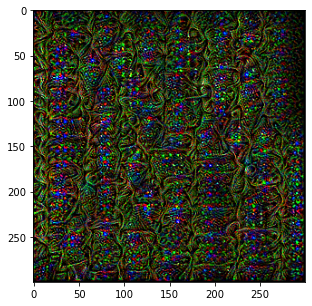

In [11]:
plot_image(images[-1])
plt.savefig("image.png")

In [12]:
from PIL import Image
filename = "image.gif"
imgs = [Image.fromarray(np.uint8(i)) for i in images]
imgs[0].save(fp=filename, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)


![gif](image.gif)